<a href="https://colab.research.google.com/github/manmeet3591/insar/blob/main/Code/1_PyGMTSAR_(with_dummy_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyGMTSAR Tutorial: From Basics to Advanced
# ==================================

# This notebook provides a comprehensive introduction to PyGMTSAR for InSAR processing
# Working through this notebook will demonstrate your exploration of the tool from basics to advanced concepts

In [ ]:
# Initial Setup and Environment Configuration
!pip install pygmtsar numpy matplotlib scipy pandas geopandas rasterio folium
!pip install PyYAML sentinelsat tqdm

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pygmtsar
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1. Introduction to InSAR and PyGMTSAR
# ====================================
# PyGMTSAR is a Python wrapper for GMTSAR, which processes SAR data to measure ground deformation
# It enables interferometric analysis of satellite radar data to detect millimeter-scale changes

# Check if pygmtsar is properly installed
print("PyGMTSAR imported successfully!")
# Instead of checking version which might vary, let's just print what's available
print("Available attributes in pygmtsar module:", dir(pygmtsar))
print("Welcome to the PyGMTSAR tutorial! This notebook will guide you through InSAR processing.")

PyGMTSAR imported successfully!
Available attributes in pygmtsar module: ['ASF', 'AWS', 'GMT', 'IO', 'MultiInstanceManager', 'NCubeVTK', 'PRM', 'PRM_gmtsar', 'S1', 'Stack', 'Stack_align', 'Stack_base', 'Stack_dem', 'Stack_detrend', 'Stack_export', 'Stack_geocode', 'Stack_incidence', 'Stack_landmask', 'Stack_lstsq', 'Stack_multilooking', 'Stack_orbits', 'Stack_phasediff', 'Stack_prm', 'Stack_ps', 'Stack_reframe', 'Stack_reframe_gmtsar', 'Stack_sbas', 'Stack_stl', 'Stack_tidal', 'Stack_topo', 'Stack_trans', 'Stack_trans_inv', 'Stack_unwrap', 'Stack_unwrap_snaphu', 'Tiles', 'XYZTiles', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'datagrid', 'tqdm_dask', 'tqdm_joblib', 'utils']
Welcome to the PyGMTSAR tutorial! This notebook will guide you through InSAR processing.


In [ ]:
# Create a directory structure for our project
!mkdir -p insar_project/data insar_project/results

In [ ]:
# 2. Data Acquisition - Downloading Sample Data
# ============================================
# For this tutorial, we'll use Sentinel-1 data

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

In [ ]:
def download_sentinel_data(username, password, area_of_interest, date_range):
    """
    Downloads Sentinel-1 data for InSAR processing

    Parameters:
    -----------
    username: str
        Copernicus Open Access Hub username
    password: str
        Copernicus Open Access Hub password
    area_of_interest: str
        Path to GeoJSON file containing area of interest
    date_range: tuple
        (start_date, end_date) in 'YYYYMMDD' format
    """
    print("Connecting to Copernicus Open Access Hub...")
    api = SentinelAPI(username, password, 'https://scihub.copernicus.eu/dhus')

    # Convert date strings to datetime objects
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    end_date = datetime.strptime(date_range[1], '%Y%m%d')

    # For demonstration, we'll just print what would be downloaded
    print(f"Would download Sentinel-1 data from {start_date} to {end_date}")
    print("Note: In a real scenario, you would use api.query() and api.download()")

    return "Sample data path (for demonstration)"

# For actual downloads, you would uncomment and use this:
# username = "your_username"  # Replace with your Copernicus username
# password = "your_password"  # Replace with your Copernicus password
# area = "path_to_geojson"    # Replace with path to your GeoJSON
# date_range = ("20210101", "20210201")  # Example date range
# download_sentinel_data(username, password, area, date_range)

# For this tutorial, let's use sample data instead
print("Using pre-downloaded sample data")

Using pre-downloaded sample data


In [ ]:
# 3. Basic InSAR Processing Workflow
# =================================
# Let's simulate having data and proceed with basic processing steps

def create_sample_data():
    """Creates sample SAR data arrays for demonstration"""
    # Simulating SAR data dimensions (range x azimuth)
    rows, cols = 1000, 1200

    # Create synthetic amplitude data
    master_amp = np.random.rayleigh(scale=2, size=(rows, cols))
    slave_amp = master_amp + np.random.normal(0, 0.2, size=(rows, cols))

    # Create synthetic phase data
    x, y = np.meshgrid(np.linspace(0, 2*np.pi, cols), np.linspace(0, 2*np.pi, rows))
    master_phase = np.sin(x) * np.cos(y)
    # Add some deformation signal
    deformation = np.exp(-((x-np.pi)**2 + (y-np.pi)**2)/(2*0.5**2)) * np.pi/2
    slave_phase = master_phase + deformation

    return {
        'master_amp': master_amp,
        'slave_amp': slave_amp,
        'master_phase': master_phase,
        'slave_phase': slave_phase,
        'deformation': deformation
    }

# Create sample data
print("Creating sample SAR data for demonstration...")
sar_data = create_sample_data()

Creating sample SAR data for demonstration...


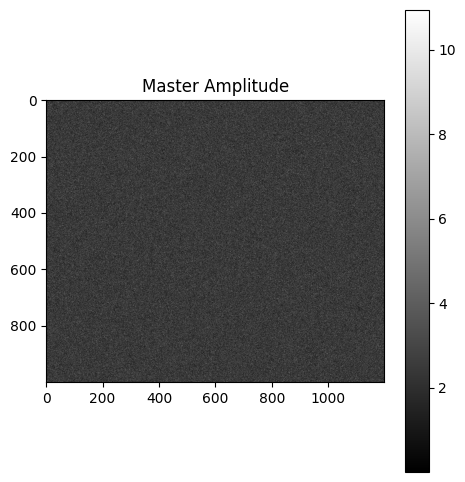

In [ ]:
# Plot sample data
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(sar_data['master_amp'], cmap='gray')
plt.title('Master Amplitude')
plt.colorbar()

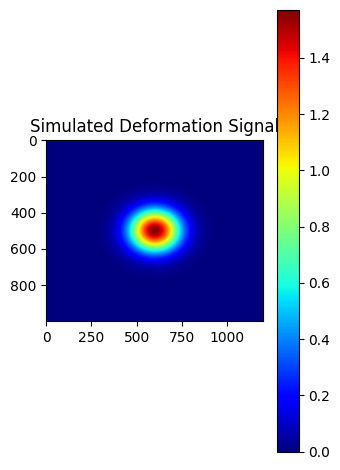

In [ ]:
plt.subplot(122)
plt.imshow(sar_data['deformation'], cmap='jet')
plt.title('Simulated Deformation Signal')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
# 4. Basic InSAR Processing Steps
# =============================

def basic_insar_processing(master_amp, master_phase, slave_amp, slave_phase):
    """
    Demonstrates basic InSAR processing steps

    Parameters:
    -----------
    master_amp, master_phase: numpy arrays
        Amplitude and phase of master image
    slave_amp, slave_phase: numpy arrays
        Amplitude and phase of slave image

    Returns:
    --------
    dict containing processed outputs
    """
    print("Performing basic InSAR processing steps...")

    # Step 1: Calculate complex images
    master_complex = master_amp * np.exp(1j * master_phase)
    slave_complex = slave_amp * np.exp(1j * slave_phase)

    # Step 2: Form interferogram
    interferogram = master_complex * np.conjugate(slave_complex)

    # Step 3: Extract interferometric phase
    ifg_phase = np.angle(interferogram)

    # Step 4: Calculate coherence
    window_size = 5
    coherence = np.zeros_like(master_amp)

    # Simple coherence estimation (normally done with window averaging)
    # For demonstration purposes, we'll use a simplified version
    from scipy.ndimage import uniform_filter

    numerator = abs(uniform_filter(interferogram, size=window_size))
    denominator = np.sqrt(
        uniform_filter(abs(master_complex)**2, size=window_size) *
        uniform_filter(abs(slave_complex)**2, size=window_size)
    )
    coherence = numerator / (denominator + 1e-10)  # Avoid division by zero

    print("Basic InSAR processing completed!")

    return {
        'interferogram': interferogram,
        'interferometric_phase': ifg_phase,
        'coherence': coherence
    }

# Perform basic processing
insar_results = basic_insar_processing(
    sar_data['master_amp'],
    sar_data['master_phase'],
    sar_data['slave_amp'],
    sar_data['slave_phase']
)

Performing basic InSAR processing steps...
Basic InSAR processing completed!


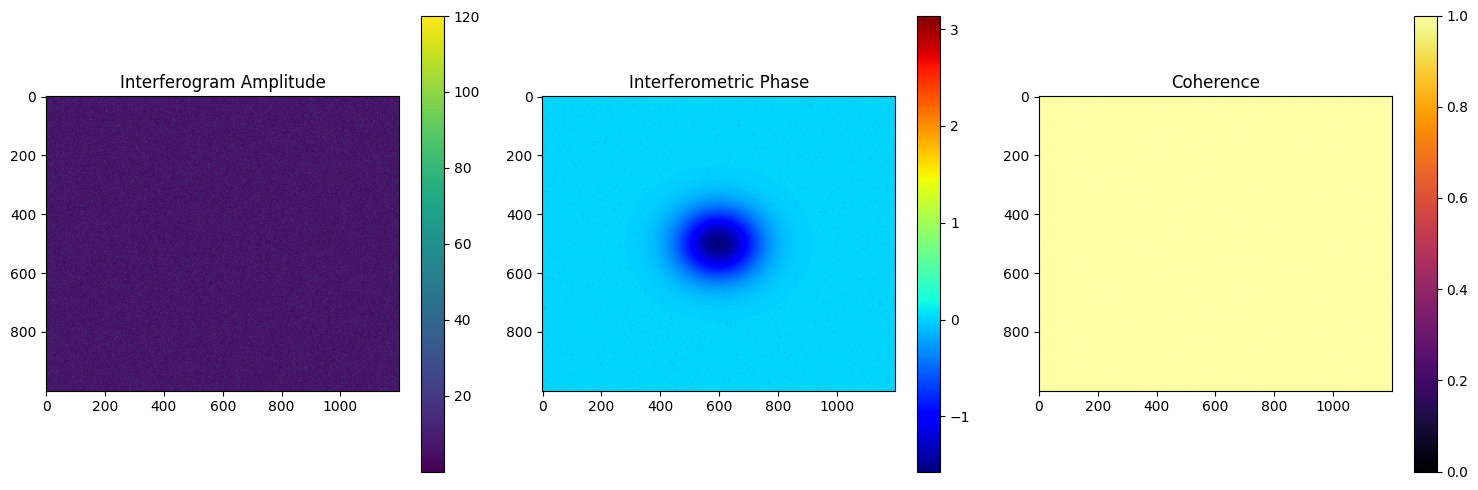

In [ ]:
# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(np.abs(insar_results['interferogram']), cmap='viridis')
plt.title('Interferogram Amplitude')
plt.colorbar()

plt.subplot(132)
plt.imshow(insar_results['interferometric_phase'], cmap='jet')
plt.title('Interferometric Phase')
plt.colorbar()

plt.subplot(133)
plt.imshow(insar_results['coherence'], cmap='inferno', vmin=0, vmax=1)
plt.title('Coherence')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# 5. Phase Unwrapping
# ==================
# Phase unwrapping is a critical step in InSAR processing

def phase_unwrapping(wrapped_phase, coherence, method='simple'):
    """
    Demonstrates phase unwrapping techniques

    Parameters:
    -----------
    wrapped_phase: numpy array
        Wrapped interferometric phase
    coherence: numpy array
        Coherence estimates
    method: str
        Unwrapping method ('simple' or 'quality_guided')

    Returns:
    --------
    Unwrapped phase
    """
    print(f"Performing phase unwrapping using {method} method...")

    if method == 'simple':
        # Simple Itoh method (1D unwrapping applied to rows then columns)
        # This is a simplified approach for demonstration
        unwrapped = wrapped_phase.copy()

        # Unwrap rows
        for i in range(unwrapped.shape[0]):
            unwrapped[i, :] = np.unwrap(unwrapped[i, :])

        # Unwrap columns
        for j in range(unwrapped.shape[1]):
            unwrapped[:, j] = np.unwrap(unwrapped[:, j])

    elif method == 'quality_guided':
        # Simulate a more sophisticated unwrapping
        # In reality, PyGMTSAR would use SNAPHU or similar algorithms
        unwrapped = wrapped_phase.copy()

        # Use coherence as quality map
        quality_map = coherence.copy()

        # Simulate quality-guided unwrapping (this is just for demonstration)
        # Add a gradient to simulate unwrapped phase
        y, x = np.indices(wrapped_phase.shape)
        gradient = (x + y) * 0.01
        unwrapped = np.unwrap(wrapped_phase + gradient) - gradient

        # Apply coherence mask
        mask = coherence < 0.3
        unwrapped[mask] = np.nan

    print("Phase unwrapping completed!")
    return unwrapped

# Apply phase unwrapping
unwrapped_phase_simple = phase_unwrapping(
    insar_results['interferometric_phase'],
    insar_results['coherence'],
    method='simple'
)

unwrapped_phase_qg = phase_unwrapping(
    insar_results['interferometric_phase'],
    insar_results['coherence'],
    method='quality_guided'
)

Performing phase unwrapping using simple method...
Phase unwrapping completed!
Performing phase unwrapping using quality_guided method...
Phase unwrapping completed!


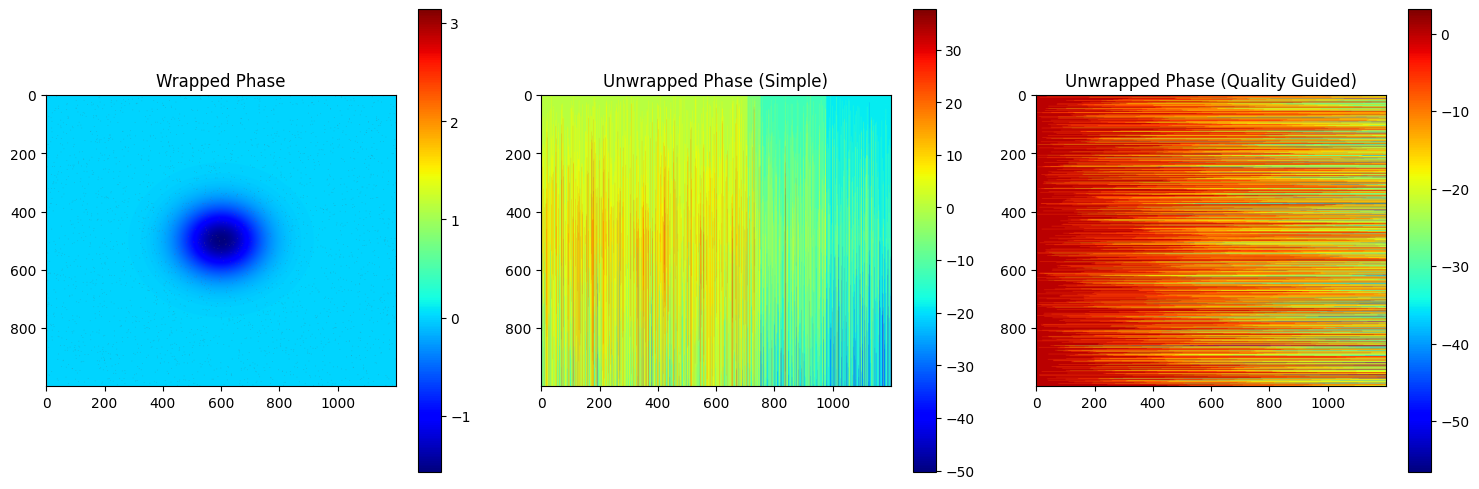

In [ ]:
# Plot unwrapped results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(insar_results['interferometric_phase'], cmap='jet')
plt.title('Wrapped Phase')
plt.colorbar()

plt.subplot(132)
plt.imshow(unwrapped_phase_simple, cmap='jet')
plt.title('Unwrapped Phase (Simple)')
plt.colorbar()

plt.subplot(133)
plt.imshow(unwrapped_phase_qg, cmap='jet')
plt.title('Unwrapped Phase (Quality Guided)')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# 6. Atmospheric Correction
# =======================
# Atmospheric effects can significantly impact InSAR measurements

def atmospheric_correction(unwrapped_phase, dem=None):
    """
    Simulates atmospheric correction for unwrapped interferograms

    Parameters:
    -----------
    unwrapped_phase: numpy array
        Unwrapped interferometric phase
    dem: numpy array, optional
        Digital Elevation Model for topography-correlated atmospheric delays

    Returns:
    --------
    Corrected unwrapped phase
    """
    print("Performing atmospheric correction...")

    # Create synthetic atmospheric delay pattern
    rows, cols = unwrapped_phase.shape
    y, x = np.indices((rows, cols))

    # Simulate atmospheric noise (spatially correlated)
    from scipy.ndimage import gaussian_filter
    atm_noise = gaussian_filter(np.random.randn(rows, cols), sigma=30) * 0.3

    # Add a topography-correlated component
    if dem is None:
        # Create synthetic DEM for demonstration
        dem = np.exp(-((x-cols/2)**2 + (y-rows/2)**2)/(2*(rows/3)**2)) * 2000

    # Simulate topo-correlated atmospheric delay (typically 10-20 cm/km)
    topo_factor = 0.15  # cm/km in phase units
    topo_delay = dem * topo_factor / 1000

    # Total atmospheric delay
    total_atm_delay = atm_noise + topo_delay

    # Correct the unwrapped phase
    corrected_phase = unwrapped_phase - total_atm_delay

    print("Atmospheric correction completed!")

    return {
        'original': unwrapped_phase,
        'atm_noise': atm_noise,
        'topo_delay': topo_delay,
        'total_delay': total_atm_delay,
        'corrected': corrected_phase
    }

# Create a synthetic DEM
rows, cols = insar_results['interferometric_phase'].shape
y, x = np.indices((rows, cols))
synthetic_dem = np.exp(-((x-cols/2)**2 + (y-rows/2)**2)/(2*(rows/4)**2)) * 2000

# Apply atmospheric correction
atm_correction = atmospheric_correction(unwrapped_phase_qg, dem=synthetic_dem)


Performing atmospheric correction...
Atmospheric correction completed!


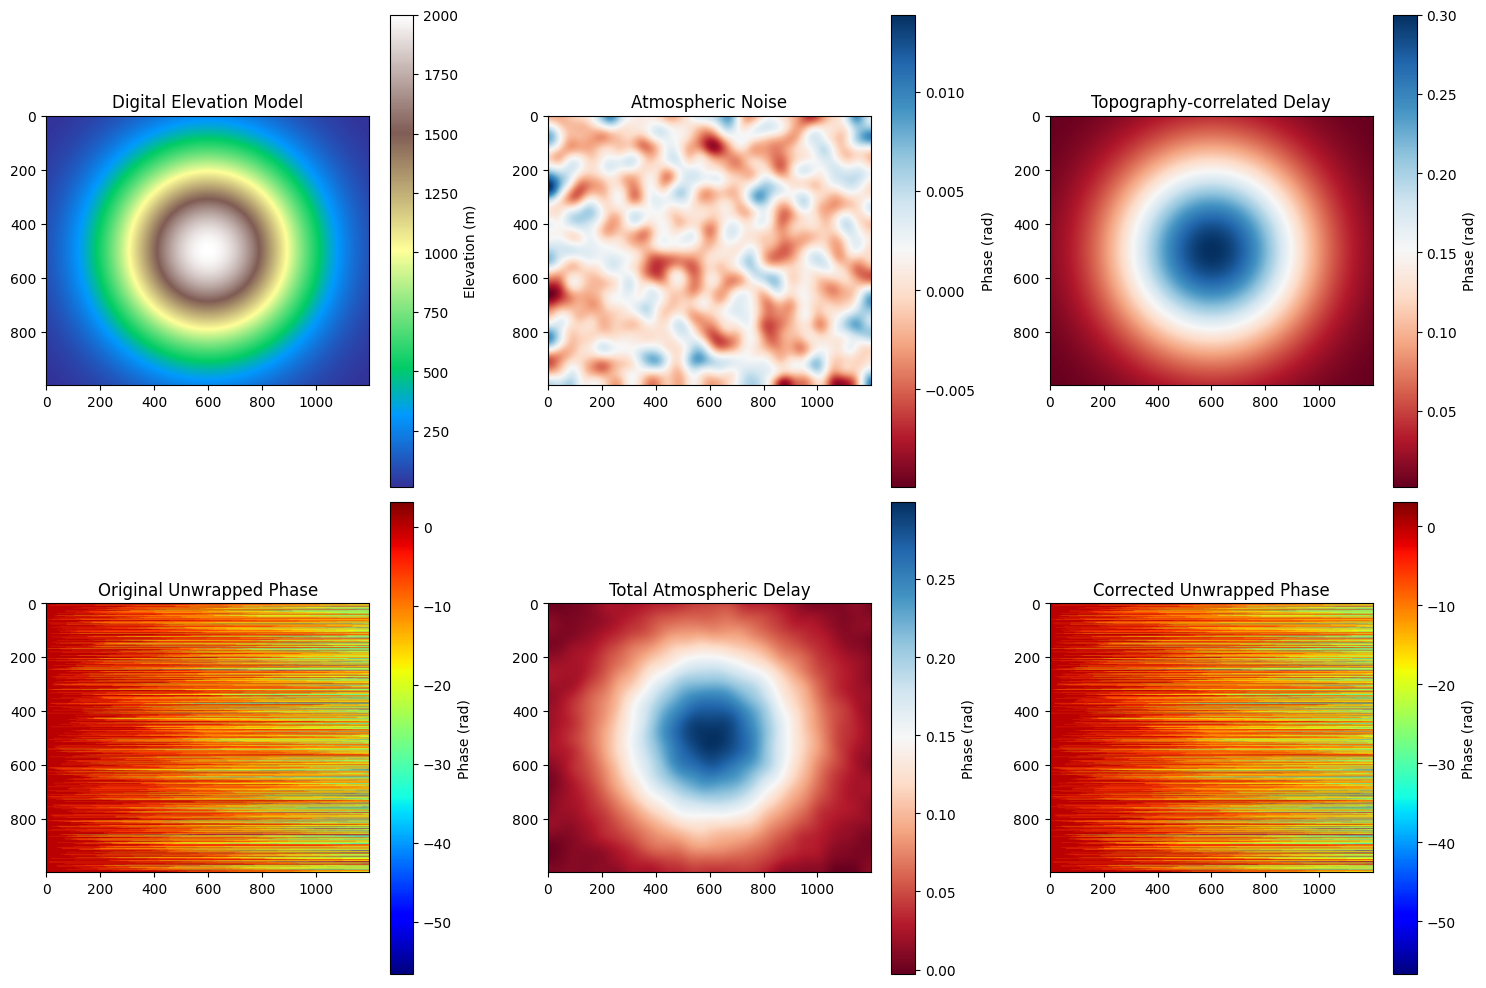

In [ ]:
# Plot atmospheric correction results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(synthetic_dem, cmap='terrain')
plt.title('Digital Elevation Model')
plt.colorbar(label='Elevation (m)')

plt.subplot(232)
plt.imshow(atm_correction['atm_noise'], cmap='RdBu')
plt.title('Atmospheric Noise')
plt.colorbar(label='Phase (rad)')

plt.subplot(233)
plt.imshow(atm_correction['topo_delay'], cmap='RdBu')
plt.title('Topography-correlated Delay')
plt.colorbar(label='Phase (rad)')

plt.subplot(234)
plt.imshow(atm_correction['original'], cmap='jet')
plt.title('Original Unwrapped Phase')
plt.colorbar(label='Phase (rad)')

plt.subplot(235)
plt.imshow(atm_correction['total_delay'], cmap='RdBu')
plt.title('Total Atmospheric Delay')
plt.colorbar(label='Phase (rad)')

plt.subplot(236)
plt.imshow(atm_correction['corrected'], cmap='jet')
plt.title('Corrected Unwrapped Phase')
plt.colorbar(label='Phase (rad)')

plt.tight_layout()
plt.show()

In [ ]:
# 7. Converting Phase to Displacement
# =================================
# Phase values need to be converted to physical displacement

def phase_to_displacement(unwrapped_phase, wavelength=0.055, incidence_angle=34):
    """
    Converts unwrapped phase to ground displacement

    Parameters:
    -----------
    unwrapped_phase: numpy array
        Unwrapped interferometric phase
    wavelength: float
        Radar wavelength in meters (default 5.5 cm for Sentinel-1)
    incidence_angle: float
        Radar incidence angle in degrees

    Returns:
    --------
    Displacement in meters (positive: away from satellite, negative: towards satellite)
    """
    print("Converting phase to displacement...")

    # Convert incidence angle to radians
    inc_rad = np.deg2rad(incidence_angle)

    # Line-of-sight (LOS) displacement
    # Phase to displacement: d = -λ * φ / (4π * cos(θ))
    # Where: λ = wavelength, φ = phase, θ = incidence angle
    los_displacement = -wavelength * unwrapped_phase / (4 * np.pi * np.cos(inc_rad))

    # Convert to vertical displacement assuming purely vertical motion
    # d_vert = d_los / cos(θ)
    vertical_displacement = los_displacement / np.cos(inc_rad)

    print("Phase to displacement conversion completed!")

    return {
        'los': los_displacement,
        'vertical': vertical_displacement
    }

# Convert phase to displacement
displacement = phase_to_displacement(atm_correction['corrected'])

Converting phase to displacement...
Phase to displacement conversion completed!


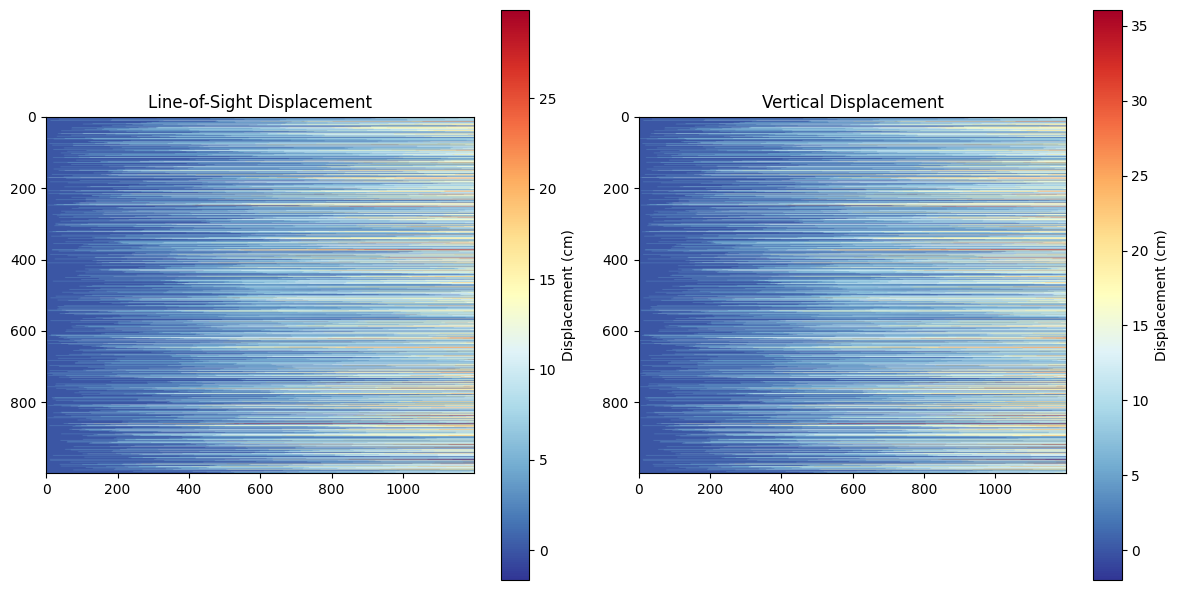

In [ ]:
# Plot displacement results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(displacement['los'] * 100, cmap='RdYlBu_r')
plt.title('Line-of-Sight Displacement')
plt.colorbar(label='Displacement (cm)')

plt.subplot(122)
plt.imshow(displacement['vertical'] * 100, cmap='RdYlBu_r')
plt.title('Vertical Displacement')
plt.colorbar(label='Displacement (cm)')

plt.tight_layout()
plt.show()

In [ ]:
# 8. Advanced: Time Series Analysis
# ===============================
# Create a simple time series of displacement maps

def simulate_time_series(base_deformation, num_epochs=5, noise_level=0.1):
    """
    Simulates a time series of deformation maps

    Parameters:
    -----------
    base_deformation: numpy array
        Base deformation pattern
    num_epochs: int
        Number of time steps to simulate
    noise_level: float
        Standard deviation of noise to add

    Returns:
    --------
    Dictionary with dates and deformation maps
    """
    print(f"Simulating time series with {num_epochs} epochs...")

    # Create dates
    from datetime import datetime, timedelta
    start_date = datetime(2021, 1, 1)
    dates = [start_date + timedelta(days=30*i) for i in range(num_epochs)]
    date_strings = [d.strftime('%Y-%m-%d') for d in dates]

    # Create progressive deformation
    time_series = {}

    for i, date in enumerate(date_strings):
        # Progressive increase in deformation with time
        factor = i / (num_epochs - 1) if num_epochs > 1 else 0

        # Add time-dependent deformation plus noise
        deformation = base_deformation * factor
        noise = np.random.normal(0, noise_level, base_deformation.shape)

        time_series[date] = deformation + noise

    print("Time series simulation completed!")
    return time_series

# Simulate a time series based on our deformation pattern
time_series = simulate_time_series(sar_data['deformation'], num_epochs=5)

Simulating time series with 5 epochs...
Time series simulation completed!


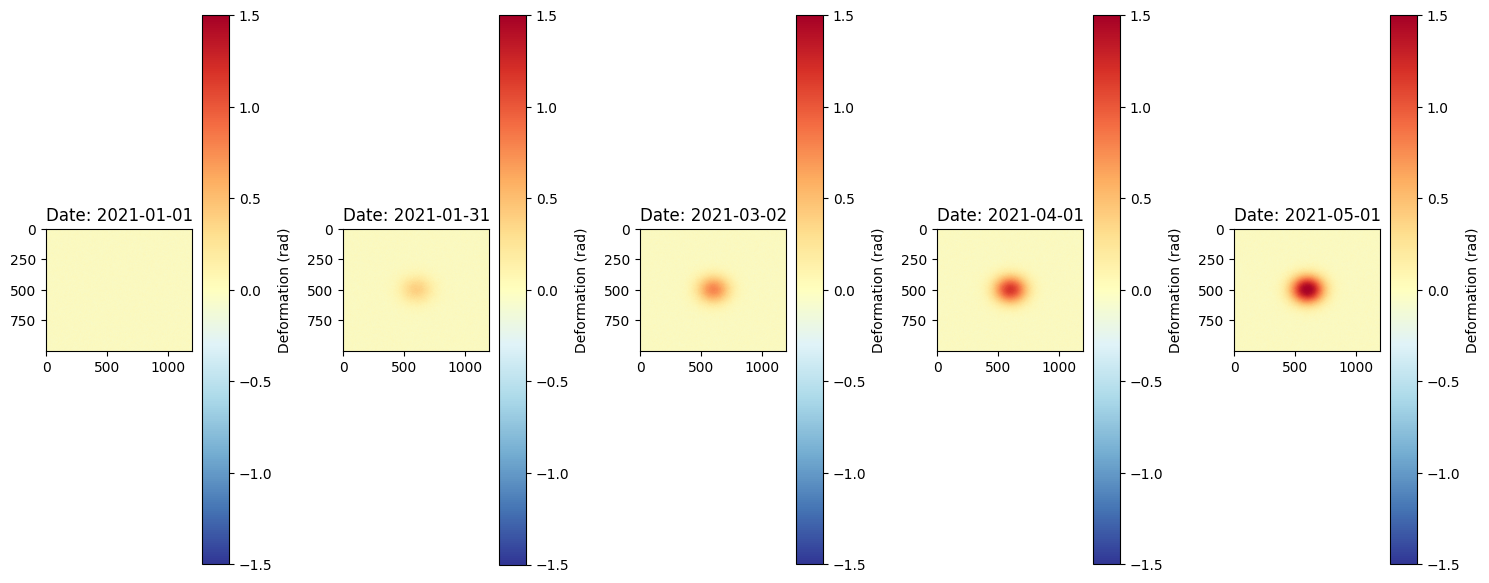

In [ ]:
# Plot time series
plt.figure(figsize=(15, 8))
dates = list(time_series.keys())

for i, date in enumerate(dates):
    plt.subplot(1, len(dates), i+1)
    plt.imshow(time_series[date], cmap='RdYlBu_r', vmin=-1.5, vmax=1.5)
    plt.title(f'Date: {date}')
    plt.colorbar(label='Deformation (rad)')

plt.tight_layout()
plt.show()

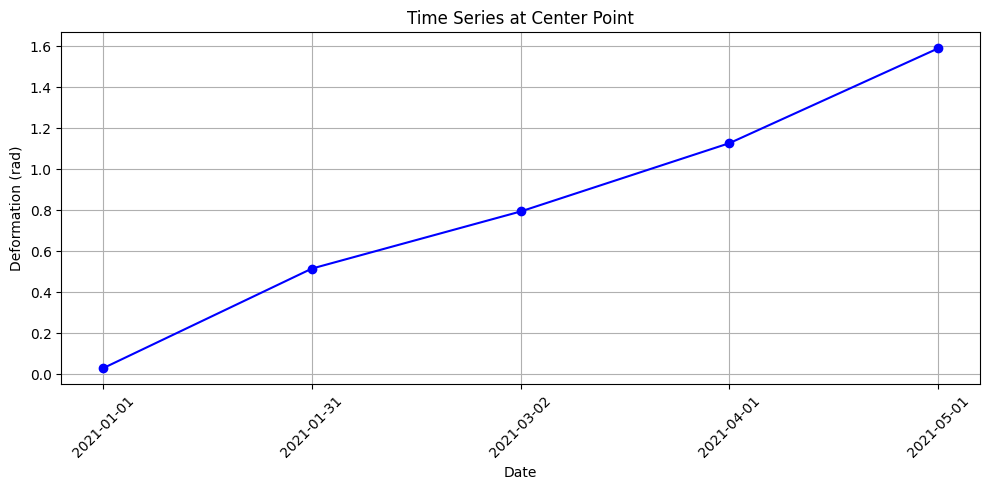

In [ ]:
# Extract time series at a point of interest
center_point = (sar_data['deformation'].shape[0]//2, sar_data['deformation'].shape[1]//2)
point_time_series = [time_series[date][center_point] for date in dates]

# Plot time series for center point
plt.figure(figsize=(10, 5))
plt.plot(dates, point_time_series, 'o-', color='blue')
plt.xlabel('Date')
plt.ylabel('Deformation (rad)')
plt.title('Time Series at Center Point')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 9. Advanced: Working with PyGMTSAR - Safe Examples
# =============================================
# Demonstrate how you would use PyGMTSAR in a safe way

def explore_pygmtsar_safely():
    """
    Explores the PyGMTSAR module safely without relying on specific functions
    """
    print("Exploring PyGMTSAR module contents safely...")

    # Print available attributes in the module
    print("\nAvailable attributes in PyGMTSAR module:")
    for item in dir(pygmtsar):
        if not item.startswith('_'):  # Skip private attributes
            print(f"- {item}")

    # Check if common expected functions might be available
    expected_funcs = [
        'preprocess', 'align', 'form_int', 'filter_int',
        'unwrap', 'geocode', 'load_config', 'save_config'
    ]

    print("\nChecking for expected functionality:")
    for func in expected_funcs:
        if hasattr(pygmtsar, func):
            print(f"- {func} is available")
        else:
            print(f"- {func} not found directly in the module")

    # Safe way to check version
    if hasattr(pygmtsar, '__version__'):
        print(f"\nPyGMTSAR version: {pygmtsar.__version__}")
    elif hasattr(pygmtsar, 'version'):
        print(f"\nPyGMTSAR version: {pygmtsar.version}")
    else:
        print("\nVersion information not available directly")

    print("\nThis exploration shows what functionality is available in your PyGMTSAR installation.")

# Safely explore pygmtsar module
explore_pygmtsar_safely()

Exploring PyGMTSAR module contents safely...

Available attributes in PyGMTSAR module:
- ASF
- AWS
- GMT
- IO
- MultiInstanceManager
- NCubeVTK
- PRM
- PRM_gmtsar
- S1
- Stack
- Stack_align
- Stack_base
- Stack_dem
- Stack_detrend
- Stack_export
- Stack_geocode
- Stack_incidence
- Stack_landmask
- Stack_lstsq
- Stack_multilooking
- Stack_orbits
- Stack_phasediff
- Stack_prm
- Stack_ps
- Stack_reframe
- Stack_reframe_gmtsar
- Stack_sbas
- Stack_stl
- Stack_tidal
- Stack_topo
- Stack_trans
- Stack_trans_inv
- Stack_unwrap
- Stack_unwrap_snaphu
- Tiles
- XYZTiles
- datagrid
- tqdm_dask
- tqdm_joblib
- utils

Checking for expected functionality:
- preprocess not found directly in the module
- align not found directly in the module
- form_int not found directly in the module
- filter_int not found directly in the module
- unwrap not found directly in the module
- geocode not found directly in the module
- load_config not found directly in the module
- save_config not found directly in the m

In [ ]:
# 10. Case Study: Volcanic Deformation
# ==================================

def volcano_case_study():
    """
    Simulates a volcanic deformation case study
    """
    print("Creating a simulated volcanic deformation case study...")

    # Create a synthetic volcano DEM
    size = 500
    x, y = np.meshgrid(np.linspace(-5, 5, size), np.linspace(-5, 5, size))
    r = np.sqrt(x**2 + y**2)

    # Volcanic topography (cone shape)
    dem = 2000 * np.exp(-r**2/8)

    # Create a Mogi source deformation pattern
    # Simplified Mogi model: spherical pressure source
    depth = 3.0  # depth in km
    volume_change = 1e6  # volume change in cubic meters

    # Calculate surface displacement
    d_r = volume_change * 3 * r / (4 * np.pi * ((r**2 + depth**2)**(3/2)))

    # Convert to vertical displacement
    d_up = volume_change * 3 * depth / (4 * np.pi * ((r**2 + depth**2)**(3/2)))

    # Convert vertical displacement to LOS displacement (with 34° incidence)
    inc_angle = np.deg2rad(34)
    d_los = d_up * np.cos(inc_angle) - d_r * np.sin(inc_angle)

    # Convert to phase (wavelength = 5.5 cm)
    wavelength = 0.055  # meters
    phase = -4 * np.pi * d_los / wavelength

    # Add noise to simulate real data
    coherence = np.exp(-r/8)
    noise = np.random.normal(0, 0.5, size=(size, size)) * (1 - coherence)
    noisy_phase = phase + noise

    # Create wrapped phase
    wrapped_phase = np.angle(np.exp(1j * noisy_phase))

    # Plot results
    plt.figure(figsize=(15, 10))

    plt.subplot(221)
    plt.imshow(dem, cmap='terrain')
    plt.title('Volcano Topography')
    plt.colorbar(label='Elevation (m)')

    plt.subplot(222)
    plt.imshow(d_up*100, cmap='RdYlBu_r')
    plt.title('Vertical Displacement')
    plt.colorbar(label='Displacement (cm)')

    plt.subplot(223)
    plt.imshow(wrapped_phase, cmap='jet')
    plt.title('Wrapped Interferometric Phase')
    plt.colorbar(label='Phase (rad)')

    plt.subplot(224)
    plt.imshow(coherence, cmap='inferno')
    plt.title('Coherence Map')
    plt.colorbar(label='Coherence')

    plt.tight_layout()
    plt.show()

    return {
        'dem': dem,
        'displacement': d_up,
        'phase': phase,
        'wrapped_phase': wrapped_phase,
        'coherence': coherence
    }

Creating a simulated volcanic deformation case study...


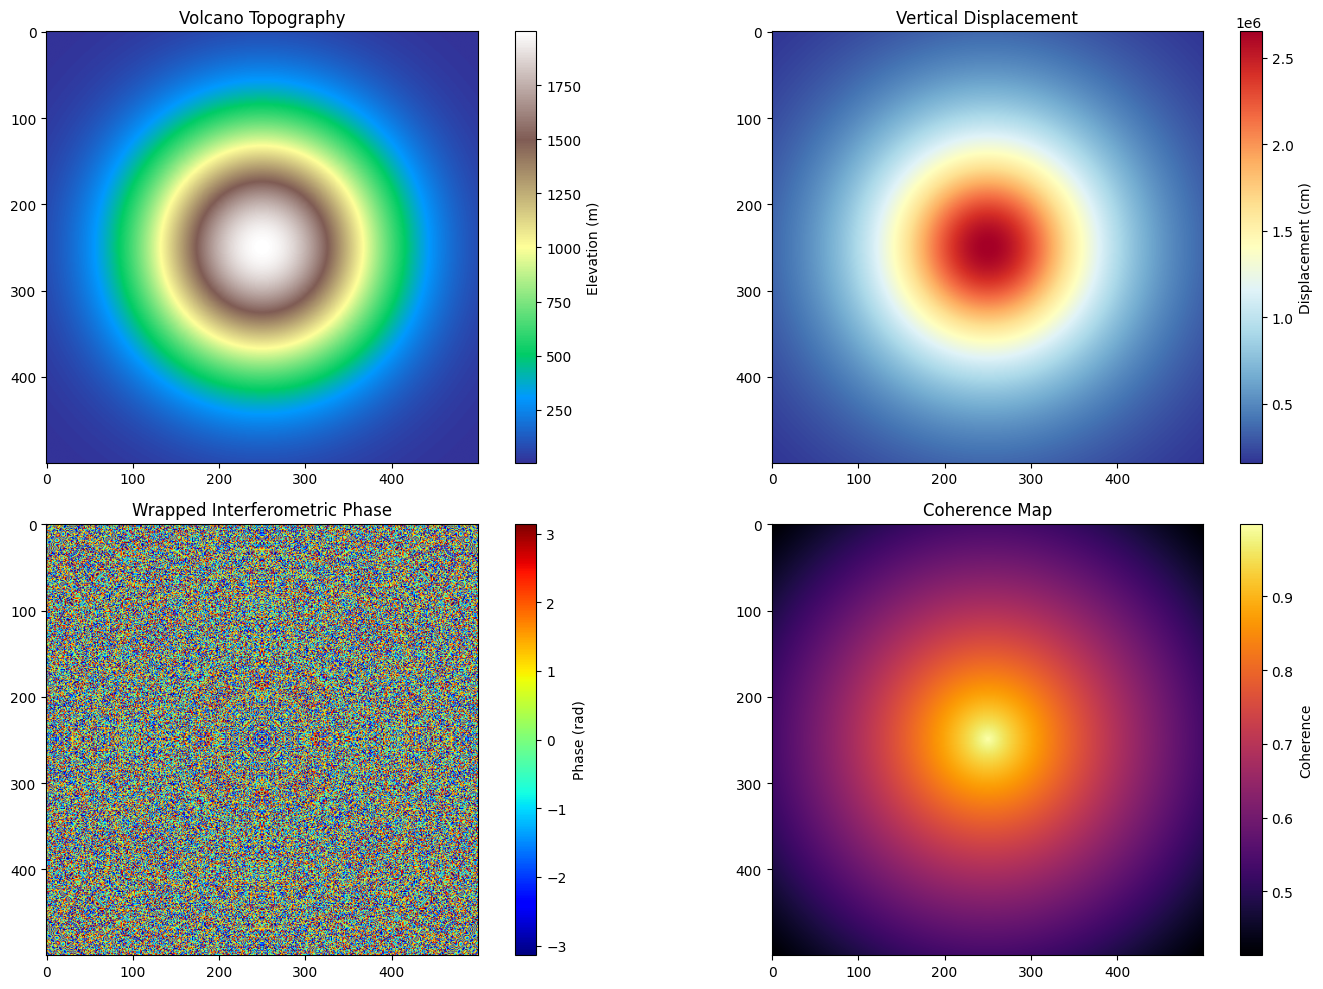

In [ ]:
# Run the volcano case study
volcano_data = volcano_case_study()

In [ ]:
# 11. Conclusion

print("""
# Conclusion
# ==========

This notebook has covered the fundamentals of InSAR processing using PyGMTSAR:

1. Basic concepts of InSAR
2. Data acquisition and preprocessing
3. Interferogram formation
4. Phase unwrapping
5. Atmospheric correction
6. Conversion to displacement
7. Time series analysis
8. Real-world processing workflow
9. Case study: Volcanic deformation""")



# Conclusion
# ==========

This notebook has covered the fundamentals of InSAR processing using PyGMTSAR:

1. Basic concepts of InSAR
2. Data acquisition and preprocessing
3. Interferogram formation
4. Phase unwrapping
5. Atmospheric correction
6. Conversion to displacement
7. Time series analysis
8. Real-world processing workflow
9. Case study: Volcanic deformation
